# Plot the KP turbine wakes (streamwise, with updraft/downdraft)

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import pickle
import pandas as pd

# Make all plots inline 
%matplotlib inline

In [2]:
extractvar = lambda xrds, var, i : xrds[var][i,:].data.reshape(tuple(xrds.attrs['ijk_dims'][::-1]))

def loadPickle(picklefname):
    pfile = open(picklefname, 'rb')
    db   = pickle.load(pfile)
    x    = db['x']
    y    = db['y']
    z    = db['z']
    vx   = db['vx']
    vy   = db['vy']
    vz   = db['vz']
    time = db['time']
    pfile.close()
    return x, y, z, vx, vy, vz, time

def avgfield(v, mintime, maxtime):
    avgv = None
    iavg = 0
    for itime, vfield in v.items():
        if (mintime<=itime) and (itime<=maxtime):
            iavg += 1
            if avgv is None:
                avgv = vfield
            else:
                avgv += vfield
    #print(iavg)
    return avgv/float(iavg)

def makecbarax(ax, c, fontsize, size='5%'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize)

def setfigtextsize(ax, fsize):
    fontelem = ([ax.title, ax.xaxis.label, ax.yaxis.label, 
                 ax.yaxis.get_offset_text(), ax.xaxis.get_offset_text()] + 
                ax.get_xticklabels() + ax.get_yticklabels() )
    for item in fontelem:
        item.set_fontsize(fsize)

In [3]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

def getTurbSubsetXY(csvfile, suffix, xlim=[-np.finfo(np.float64).max, np.finfo(np.float64).max], ylim=[-np.finfo(np.float64).max, np.finfo(np.float64).max]):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        xy = [float(x[1][' x']), float(x[1][' y'])]
        if x[1]['# name'].endswith(suffix) and ((xlim[0] <= xy[0]) and (xy[0]<=xlim[1]) and (ylim[0]<=xy[1]) and (xy[1]<=ylim[1])):
            #print(x[1])
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

def getCartesianMesh(x,y):
    p00=np.array([x[0,0], y[0,0]])
    p10=np.array([x[1,0], y[1,0]])
    p01=np.array([x[0,1], y[0,1]])
    dx=np.linalg.norm(p00-p10)
    dy=np.linalg.norm(p00-p01)
    hhshape=x.shape
    xvec=np.arange(hhshape[1])*dx
    yvec=np.arange(hhshape[0])*dy
    xm, ym = np.meshgrid(xvec, yvec)
    return xm, ym
    #return xm.transpose(), ym.transpose()

def avgFileList(turblist, tavg1, tavg2):
    avgvx = None
    avgvy = None
    avgvz = None
    for turb in turblist:
        x, y, z, vx, vy, vz, time = loadPickle(turb)
        vx_avg = avgfield(vx, tavg1, tavg2)
        vy_avg = avgfield(vy, tavg1, tavg2)
        vz_avg = avgfield(vz, tavg1, tavg2)
        if avgvx is None:
            avgvx = vx_avg
            avgvy = vy_avg
            avgvz = vz_avg
        else:
            avgvx += vx_avg
            avgvy += vy_avg
            avgvz += vz_avg
    N = len(turblist)
    return x, y, z, avgvx/N, avgvy/N, avgvz/N

In [4]:
summitcsv    = '../UnstableABL_farmrun_turbines.csv'
pkldir       = 'means/KPturbssw.2/'
turbname     = '%s_sw_mean_%s.pkl'
tavg1 = 300
tavg2 = 999

In [5]:
allturblist = getturbnames(getTurbSubset(summitcsv, '-KP'))

In [6]:
#split the turbines into updraft/downdraft
posW_noturbfiles = [] #[pkldir+'/'+turbname%(x, 'noturb') for x in allturblist]
posW_wturbfiles  = [] #[pkldir+'/'+turbname%(x, 'wturb') for x in allturblist]
negW_noturbfiles = []
negW_wturbfiles  = []

for turb in allturblist[:]:
    # Load the no turbine dir
    noturbpkl = pkldir+'/'+turbname%(turb, 'noturb')
    wturbpkl  = pkldir+'/'+turbname%(turb, 'wturb')
    x, y, z, vx, vy, vz, time = loadPickle(noturbpkl)
    vx_avg_not = avgfield(vx, tavg1, tavg2)
    vy_avg_not = avgfield(vy, tavg1, tavg2)
    vz_avg_not = avgfield(vz, tavg1, tavg2)
    vz_avg_avg = np.mean(vz_avg_not)
    print('%s : %f'%(turb, vz_avg_avg))
    if vz_avg_avg > 0.0:
        posW_noturbfiles.append(pkldir+'/'+turbname%(turb, 'noturb'))
        posW_wturbfiles.append(pkldir+'/'+turbname%(turb, 'wturb'))
    else:
        negW_noturbfiles.append(pkldir+'/'+turbname%(turb, 'noturb'))
        negW_wturbfiles.append(pkldir+'/'+turbname%(turb, 'wturb'))
        
print('Number of turbines in updraft: %i'%len(posW_noturbfiles))
print('Number of turbines in downdraft: %i'%len(negW_noturbfiles))

2019-WTW-4713-KP : -0.102953
2019-WTW-4655-KP : 0.175078
2019-WTW-4651-KP : 0.442769
2019-WTW-4726-KP : -0.120114
2019-WTW-4671-KP : -0.147489
2019-WTW-4715-KP : 0.423922
2019-WTW-4691-KP : 0.335047
2019-WTW-7913-KP : -0.114634
2019-WTW-4657-KP : -0.156407
2019-WTW-4694-KP : -0.109870
2019-WTW-4718-KP : 0.089153
2019-WTW-4690-KP : -0.114403
2019-WTW-4656-KP : -0.037781
2019-WTW-4697-KP : -0.138856
2019-WTW-4698-KP : -0.124367
2019-WTW-4701-KP : -0.154142
2019-WTW-4723-KP : 0.095964
2019-WTW-4673-KP : -0.368444
2019-WTW-4716-KP : -0.017721
2019-WTW-4693-KP : 0.161912
2019-WTW-4725-KP : -0.249746
2019-WTW-7915-KP : 0.106057
2019-WTW-4674-KP : -0.154428
2019-WTW-4689-KP : -0.083601
2019-WTW-7921-KP : 0.222678
2019-WTW-4710-KP : -0.207263
2019-WTW-4648-KP : -0.095141
2019-WTW-4721-KP : -0.154820
2019-WTW-4652-KP : 0.204196
2019-WTW-4658-KP : -0.148427
2019-WTW-4692-KP : 0.287527
2019-WTW-4695-KP : 0.156771
2019-WTW-7914-KP : 0.335006
2019-WTW-4675-KP : 0.010165
2019-WTW-4702-KP : -0.097554

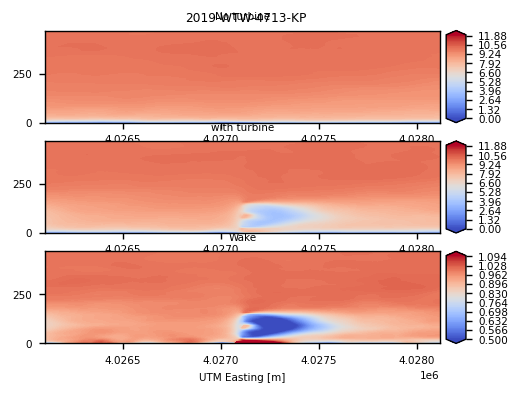

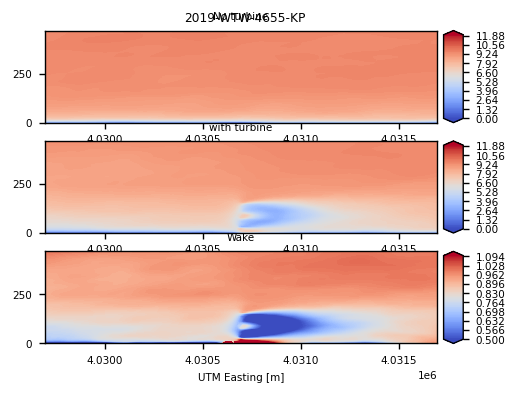

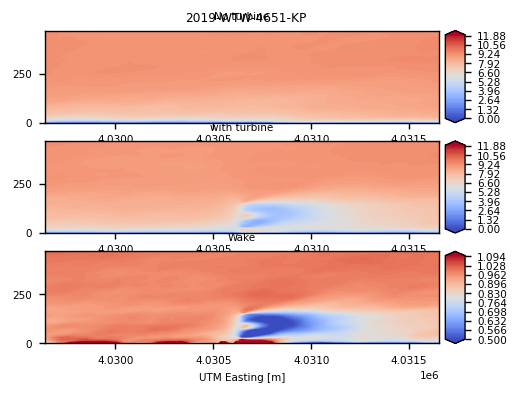

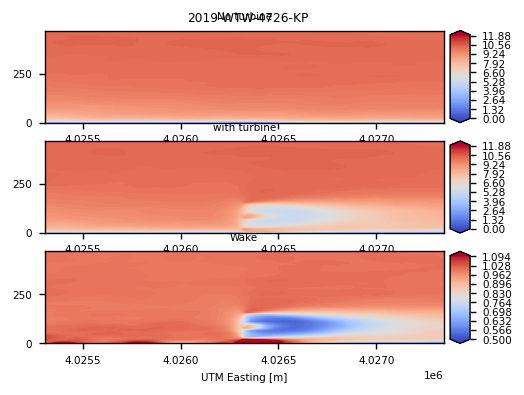

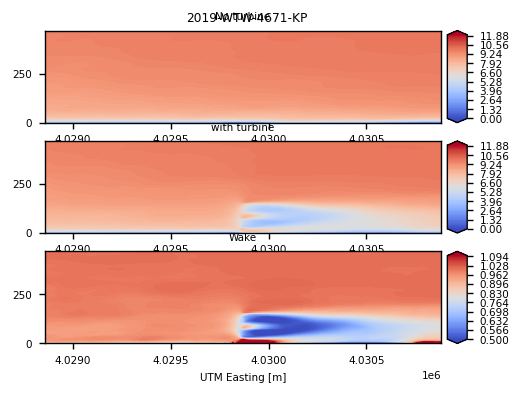

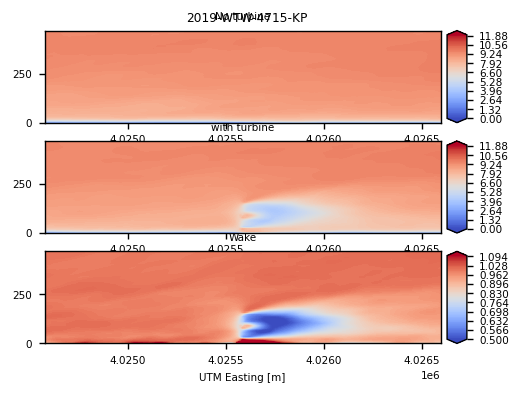

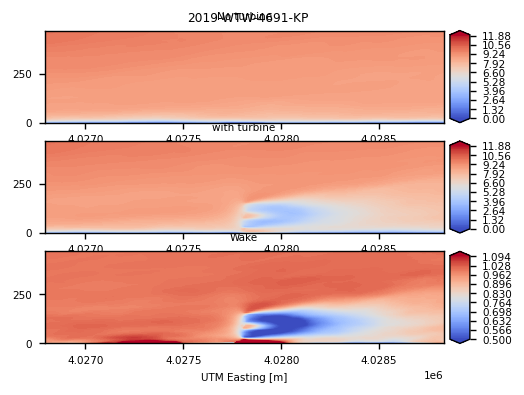

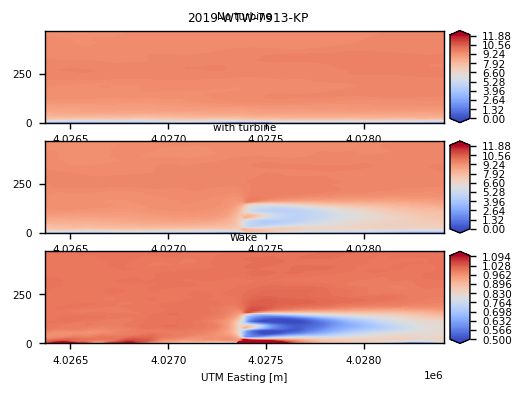

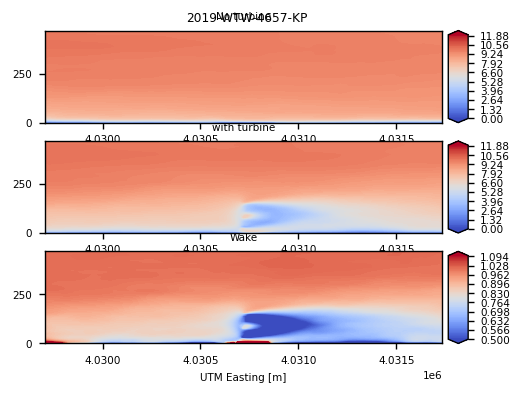

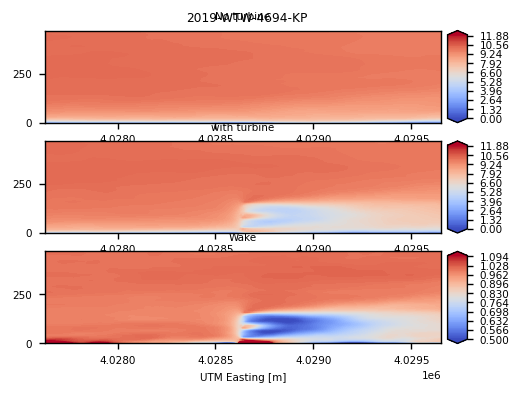

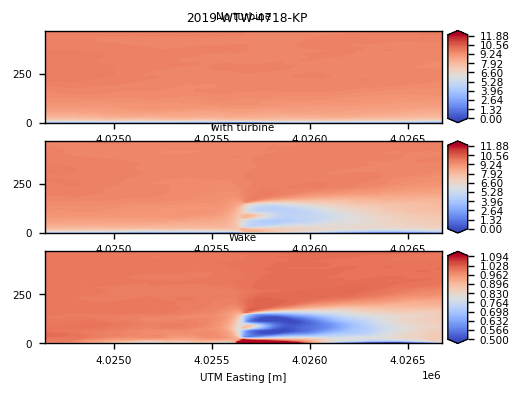

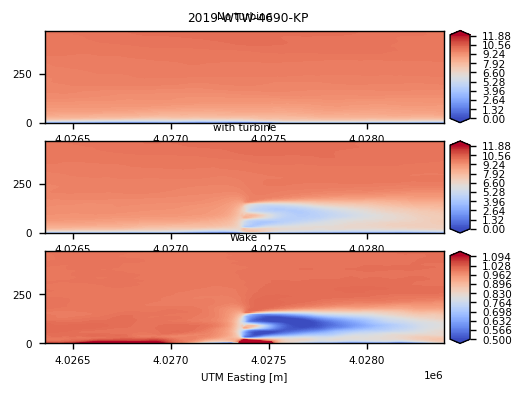

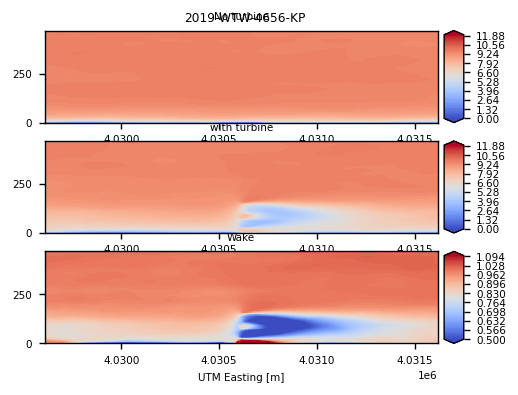

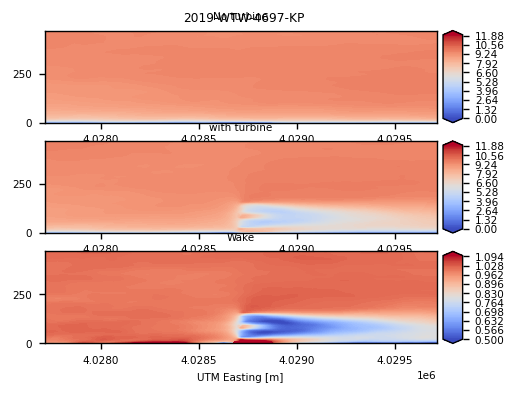

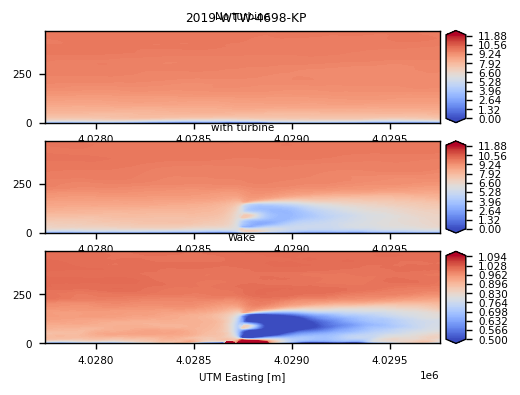

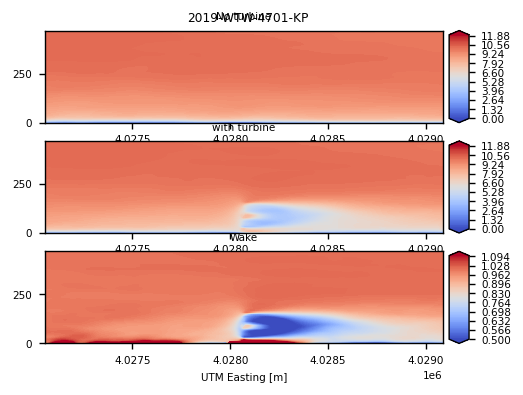

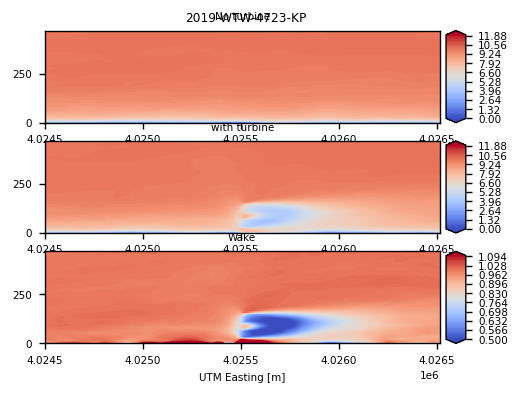

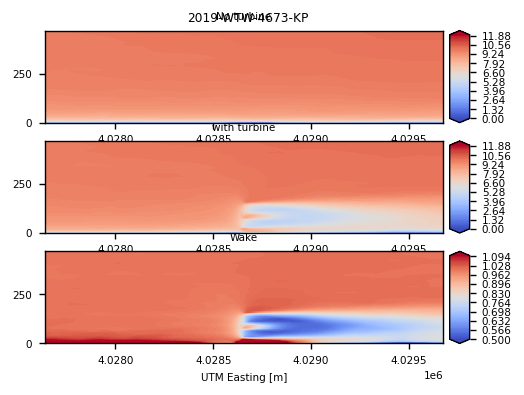

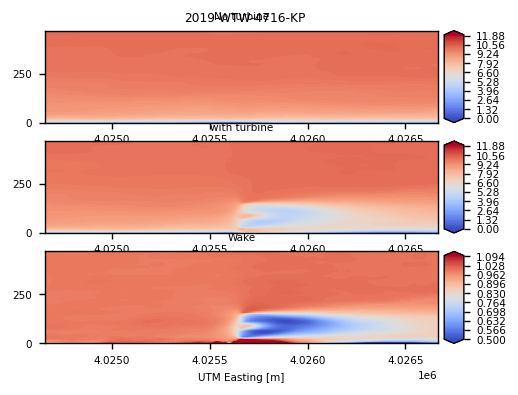

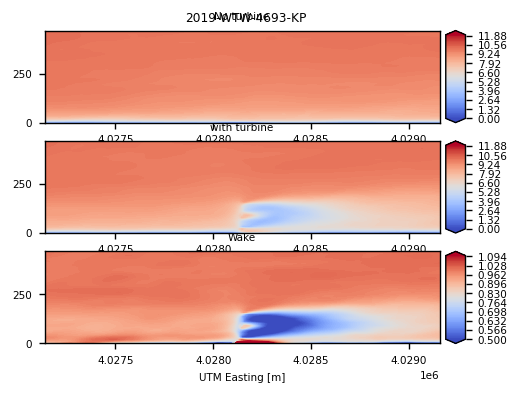

In [7]:
vlevels = np.linspace(0, 12,101)
difflevels = np.linspace(0.5, 1.1, 101)
zlevels = np.linspace(-1.5,1.5,101)
fontsize = 6
resetgrid= False

for turb in allturblist[:20]:
    fig, axs = plt.subplots(3,1,figsize=(6,3.25), dpi=125, sharey=False)
    # Load the no turbine dir
    noturbpkl = pkldir+'/'+turbname%(turb, 'noturb')
    wturbpkl  = pkldir+'/'+turbname%(turb, 'wturb')
    x, y, z, vx, vy, vz, time = loadPickle(noturbpkl)
    vx_avg_not = avgfield(vx, tavg1, tavg2)
    vy_avg_not = avgfield(vy, tavg1, tavg2)
    vz_avg_not = avgfield(vz, tavg1, tavg2)
    
    x, y, z, vx, vy, vz, time = loadPickle(wturbpkl)
    vx_avg_wt = avgfield(vx, tavg1, tavg2)
    vy_avg_wt = avgfield(vy, tavg1, tavg2)
    vz_avg_wt = avgfield(vz, tavg1, tavg2)
    
    if resetgrid:
        xm, ym = getCartesianMesh(x,y)
        scale = 127
        x0 = np.mean(xm)
        y0 = np.mean(ym)
        xp, yp = (xm-x0)/scale, (ym-y0)/scale
        xlabel = 'x/D'
    else:
        xp, yp = y,z
        xlabel = 'UTM Easting [m]'
    
    # plot the no turbine mean flow case
    ax=axs[0]
    vh_not = np.sqrt(vx_avg_not**2 + vy_avg_not**2)
    c=ax.contourf(xp, yp, vh_not[0,:,:], levels=vlevels, cmap='coolwarm', extend='both')
    makecbarax(ax, c, fontsize)
    ax.set_aspect('equal')
    #ax.set_xlabel(xlabel)
    ax.set_title('No turbine')
    setfigtextsize(ax, fontsize)
    
    # plot the no turbine mean flow case
    ax=axs[1]
    vh_wt = np.sqrt(vx_avg_wt**2 + vy_avg_wt**2)
    vz_wt = vz_avg_wt
    #c=ax.contourf(xp, yp, vz_wt[0,:,:], levels=zlevels, cmap='coolwarm', extend='both')
    c=ax.contourf(xp, yp, vh_wt[0,:,:], levels=vlevels, cmap='coolwarm', extend='both')
    makecbarax(ax, c, fontsize)
    ax.set_aspect('equal')
    #ax.set_xlabel(xlabel)
    ax.set_title('with turbine')
    setfigtextsize(ax, fontsize)
    
    # plot the difference
    ax=axs[2]
    vh_diff = np.sqrt((vx_avg_not-vx_avg_wt)**2 + (vx_avg_not-vy_avg_wt)**2)
    c=ax.contourf(xp, yp, vh_wt[0,:,:]/vh_not[0,:,:], levels=difflevels, cmap='coolwarm', extend='both')
    makecbarax(ax, c, fontsize)
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_title('Wake')
    setfigtextsize(ax, fontsize)
    
    fig.suptitle(turb, y=0.925, fontsize =fontsize+1) 

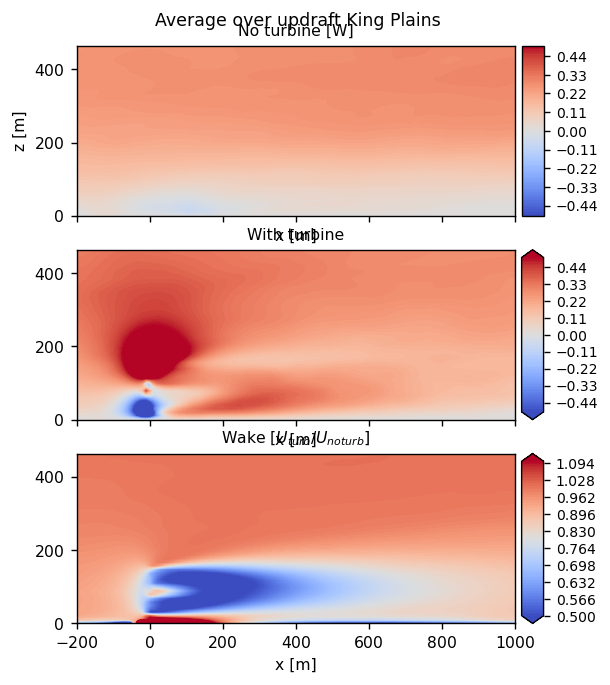

In [8]:
allnoturbfiles = [pkldir+'/'+turbname%(x, 'noturb') for x in allturblist]
allwturbfiles  = [pkldir+'/'+turbname%(x, 'wturb') for x in allturblist]

x,y,z, avg_vx_noturb, avg_vy_noturb, avg_vz_noturb  = avgFileList(posW_noturbfiles, tavg1, tavg2)
x,y,z, avg_vx_wturb,  avg_vy_wturb,  avg_vz_wturb  = avgFileList(posW_wturbfiles, tavg1, tavg2)

xm, ym = getCartesianMesh(y,z)
scale = 127
x0 = np.mean(xm)
y0 = np.mean(ym)
#print(np.min(xp))
#print(xp)
xp, yp = (xm)-1020, (ym)

fontsize=9
xlabel = 'x [m]'
ylabel = 'z [m]'
fig, axs = plt.subplots(3,1,figsize=(8,6), dpi=125, sharex=True)

vh_not = np.sqrt(avg_vx_noturb**2 + avg_vy_noturb**2)
vh_wt = np.sqrt(avg_vx_wturb**2 + avg_vy_wturb**2)
vh_diff = np.sqrt((avg_vx_noturb-avg_vx_wturb)**2 + (avg_vy_noturb-avg_vy_wturb)**2)

wlevels = np.linspace(-0.5,0.5,101)

ax=axs[0]
c=ax.contourf(xp, yp, avg_vz_noturb[0,:,:], levels=wlevels, cmap='coolwarm')
makecbarax(ax, c, fontsize-1, size='5%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([-1, 8])
ax.set_title('No turbine [W]')
setfigtextsize(ax, fontsize)

ax=axs[1]
#c=ax.contourf(xp, yp, vh_wt[0,:,:], levels=vlevels, cmap='coolwarm')
c=ax.contourf(xp, yp, avg_vz_wturb[0,:,:], levels=wlevels, cmap='coolwarm', extend='both')
makecbarax(ax, c, fontsize-1, size='5%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
#ax.set_ylim([-1, 8])
ax.set_title('With turbine')
setfigtextsize(ax, fontsize)

ax=axs[2]
#c=ax.contourf(xp, yp,1-vh_diff[0,:,:]/vh_not[0,:,:], levels=difflevels, cmap='coolwarm', extend='both')
c=ax.contourf(xp, yp,vh_wt[0,:,:]/vh_not[0,:,:], levels=difflevels, cmap='coolwarm', extend='both')
makecbarax(ax, c, fontsize-1, size='5%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
#ax.set_ylim([-2, 8])
#ax.set_xlim([800,2000])
ax.set_xlim([-200,1000])
ax.set_title('Wake [$U_{turb}/U_{noturb}$]')
setfigtextsize(ax, fontsize)

fig.suptitle('Average over updraft King Plains', y=0.925, fontsize =fontsize+1);

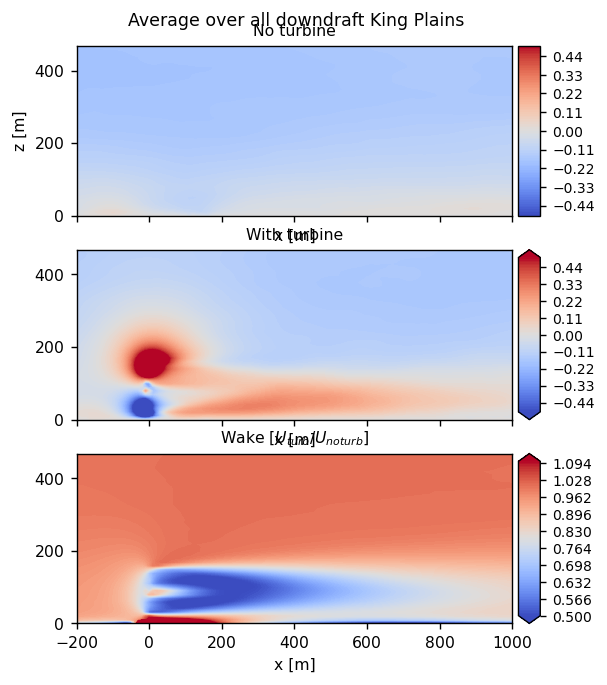

In [9]:
x,y,z, avg_vx_noturb, avg_vy_noturb, avg_vz_noturb  = avgFileList(negW_noturbfiles, tavg1, tavg2)
x,y,z, avg_vx_wturb, avg_vy_wturb, avg_vz_wturb  = avgFileList(negW_wturbfiles, tavg1, tavg2)

xm, ym = getCartesianMesh(y,z)
scale = 127
x0 = np.mean(xm)
y0 = np.mean(ym)
#xp, yp = (xm), (ym)
xp, yp = (xm)-1020, (ym)

fontsize=9
xlabel = 'x [m]'
ylabel = 'z [m]'
fig, axs = plt.subplots(3,1,figsize=(8,6), dpi=125, sharex=True)

vh_not = np.sqrt(avg_vx_noturb**2 + avg_vy_noturb**2)
vh_wt = np.sqrt(avg_vx_wturb**2 + avg_vy_wturb**2)
vh_diff = np.sqrt((avg_vx_noturb-avg_vx_wturb)**2 + (avg_vy_noturb-avg_vy_wturb)**2)

wlevels = np.linspace(-0.5,0.5,101)

ax=axs[0]
#c=ax.contourf(xp, yp, vh_not[0,:,:], levels=vlevels, cmap='coolwarm')
c=ax.contourf(xp, yp, avg_vz_noturb[0,:,:], levels=wlevels, cmap='coolwarm')
makecbarax(ax, c, fontsize-1, size='5%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([-1, 8])
ax.set_title('No turbine')
setfigtextsize(ax, fontsize)

ax=axs[1]
#c=ax.contourf(xp, yp, vh_wt[0,:,:], levels=vlevels, cmap='coolwarm')
c=ax.contourf(xp, yp, avg_vz_wturb[0,:,:], levels=wlevels, cmap='coolwarm', extend='both')
makecbarax(ax, c, fontsize-1, size='5%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
#ax.set_ylim([-1, 8])
ax.set_title('With turbine')
setfigtextsize(ax, fontsize)

ax=axs[2]
c=ax.contourf(xp, yp,vh_wt[0,:,:]/vh_not[0,:,:], levels=difflevels, cmap='coolwarm', extend='both')
makecbarax(ax, c, fontsize-1, size='5%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
#ax.set_ylim([-2, 8])
#ax.set_xlim([800,2000])
#ax.set_title('Wake')
ax.set_xlim([-200,1000])
ax.set_title('Wake [$U_{turb}/U_{noturb}$]')
setfigtextsize(ax, fontsize)

fig.suptitle('Average over all downdraft King Plains', y=0.925, fontsize =fontsize+1);

In [10]:
x,y,z, avg_vx_noturb, avg_vy_noturb, avg_vz_noturb  = avgFileList(allnoturbfiles, tavg1, tavg2)
x,y,z, avg_vx_wturb,  avg_vy_wturb,  avg_vz_wturb   = avgFileList(allwturbfiles, tavg1, tavg2)
xm, ym = getCartesianMesh(y,z)

x,y,z, avg_vx_noturb_pW, avg_vy_noturb_pW, avg_vz_noturb_pW  = avgFileList(posW_noturbfiles, tavg1, tavg2)
x,y,z, avg_vx_wturb_pW,  avg_vy_wturb_pW,  avg_vz_wturb_pW  = avgFileList(posW_wturbfiles, tavg1, tavg2)
xm, ym = getCartesianMesh(y,z)

x,y,z, avg_vx_noturb_nW, avg_vy_noturb_nW, avg_vz_noturb_nW  = avgFileList(negW_noturbfiles, tavg1, tavg2)
x,y,z, avg_vx_wturb_nW, avg_vy_wturb_nW, avg_vz_wturb_nW  = avgFileList(negW_wturbfiles, tavg1, tavg2)
xm, ym = getCartesianMesh(y,z)

x0 = np.mean(xm)
y0 = np.mean(ym)
#xp, yp = (xm), (ym)
xp, yp = (xm)-1020, (ym)

vh_not    = np.sqrt(avg_vx_noturb**2 + avg_vy_noturb**2)
vh_wt     = np.sqrt(avg_vx_wturb**2 + avg_vy_wturb**2)

vh_not_pW = np.sqrt(avg_vx_noturb_pW**2 + avg_vy_noturb_pW**2)
vh_wt_pW  = np.sqrt(avg_vx_wturb_pW**2 + avg_vy_wturb_pW**2)

vh_not_nW = np.sqrt(avg_vx_noturb_nW**2 + avg_vy_noturb_nW**2)
vh_wt_nW  = np.sqrt(avg_vx_wturb_nW**2 + avg_vy_wturb_nW**2)


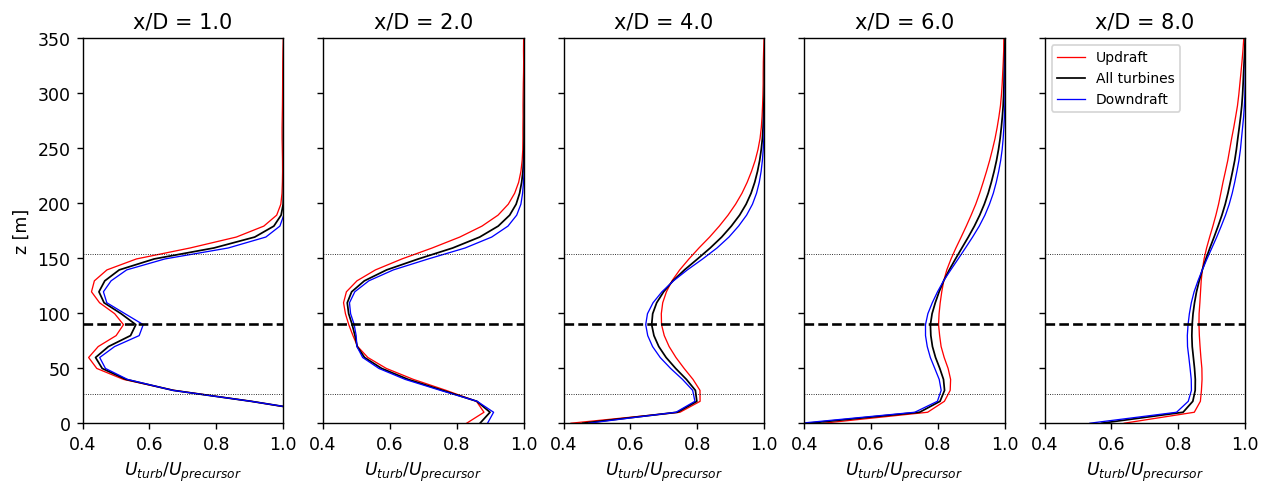

In [15]:
yvec=yp[:,0]
xvec=xp[0,:]
ivec = [115, 127, 153, 178, 204]
#print(xvec[i]/scale)
fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
for ix, ax in enumerate(axs):
    i = ivec[ix]
    ax.plot(vh_wt_pW[0,:,i]/vh_not_pW[0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(vh_wt[0,:,i]/vh_not[0,:,i], yvec,       'k', lw=1.0, label='All turbines')
    ax.plot(vh_wt_nW[0,:,i]/vh_not_nW[0,:,i], yvec, 'b', lw=0.75, label='Downdraft')
    ax.set_xlim([0.4, 1])
    ax.set_ylim([0, 350])
    ax.set_xlabel('$U_{turb}/U_{precursor}$')
    ax.axhline(90, ls='--', color='k')
    ax.axhline(90+0.5*127, ls=':', color='k', lw=0.5)
    ax.axhline(90-0.5*127, ls=':', color='k', lw=0.5)
    ax.set_title('x/D = %0.1f'%(xvec[i]/127))
    

axs[0].set_ylabel('z [m]')    
axs[-1].legend(prop={'size': 8})

In [12]:
summitcsv    = '../UnstableABL_farmrun_turbines.csv'

def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

KPturbdf = getTurbSubset(summitcsv, '-KP')

Loading farm King Plains Turbine Locations


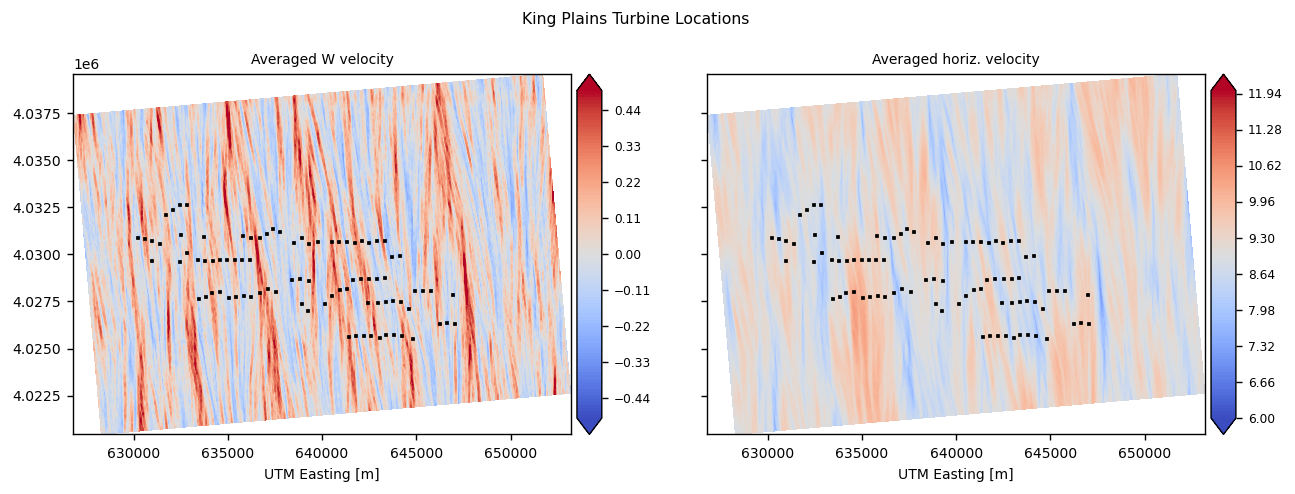

In [13]:
tavg1 = 300
tavg2 = 999
itime = 900
rundir='/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/testturbs/post_processing'
farmlist = [{'title':'King Plains Turbine Locations', 'figsize':(12,4.5),
             'ncfile':'KP_z090hh_64500.nc',
             'noturb':'means/KP_z90_mean_noturb.pkl',
             'wturb':'means/KP_z90_mean_wturb.pkl'},
          ]

vlevels = np.linspace(6,12,101)
fontsize = 8
    
for farm in farmlist[:4]:
    print('Loading farm '+farm['title'])
    fig, axs = plt.subplots(1,2,figsize=farm['figsize'], dpi=125, sharey=True)
    ax=axs[0]
    groups=ppsample.getGroups(ppsample.loadDataset(rundir+'/'+farm['ncfile']))
    with xr.open_dataset(rundir+'/'+farm['ncfile'], group=groups[0]) as ds:
        xm = ds['coordinates'].data[:,0].reshape(tuple(ds.attrs['ijk_dims'][1::-1]))
        ym = ds['coordinates'].data[:,1].reshape(tuple(ds.attrs['ijk_dims'][1::-1]))
        dtime=xr.open_dataset(rundir+'/'+farm['ncfile'])
        ds = ds.assign_coords(coords={'xm':(['x','y'], xm),
                                      'ym':(['x','y'], ym),
                                      'time':dtime['time'],
                                     })
        dtime.close()
    
    # ==== Get and plot the average === 
    x, y, z, vx, vy, vz, time = loadPickle(farm['noturb'])
    vx_avg_wt = avgfield(vx, tavg1, tavg2)
    vy_avg_wt = avgfield(vy, tavg1, tavg2)
    vz_avg_wt = avgfield(vz, tavg1, tavg2)
    wlevels=np.linspace(-0.5, 0.5, 101)
    
    ax=axs[0]
    c=ax.contourf(x, y, vz_avg_wt[0,:,:], levels=wlevels, cmap='coolwarm', extend='both')
    for t in KPturbdf.iterrows():    ax.plot(float(t[1][' x']), float(t[1][' y']), 'ks', markersize=1.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize-1)
    ax.set_aspect('equal')
    ax.set_xlabel('UTM Easting [m]')
    ax.set_title('Averaged W velocity')    
    setfigtextsize(ax, fontsize)
    
    # plot the with turbine mean flow case
    ax=axs[1]

    vh = np.sqrt(vx_avg_wt**2 + vy_avg_wt**2)
    c=ax.contourf(x, y, vh[0,:,:], levels=vlevels, cmap='coolwarm', extend='both')
    for t in KPturbdf.iterrows():    ax.plot(float(t[1][' x']), float(t[1][' y']), 'ks', markersize=1.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize-1)
    ax.set_aspect('equal')
    ax.set_xlabel('UTM Easting [m]')
    ax.set_title('Averaged horiz. velocity')
    setfigtextsize(ax, fontsize)
    
    fig.suptitle(farm['title'], y=0.925, fontsize =fontsize+1)
    
    del vx
    del vy
    del vh